In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [34]:
image_file = 'working.jpg'
input_image = cv2.imread(image_file, 1)
image = np.array(input_image)

In [35]:
def gray(imagen):
    imagen_gris = np.zeros((imagen.shape[0], imagen.shape[1]), dtype=np.uint8)
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):            
            r, g, b = imagen[i, j]
            gris = int(0.299 * r + 0.587 * g + 0.114 * b)
            imagen_gris[i, j] = gris
    return imagen_gris

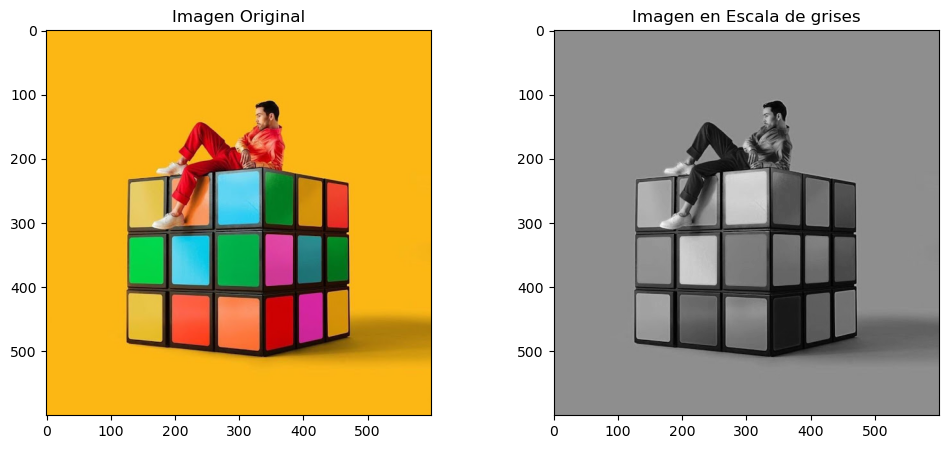

In [36]:
imagen_gris = gray(image) 
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax1, ax2 = axs.flatten()

ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Imagen Original')

ax2.set_title('Imagen en Escala de grises')
ax2.imshow(imagen_gris, cmap='gray')
plt.show()

In [37]:
def convolucion(img, kernel):
    kernelint = math.floor(kernel.shape[0]/2)
    channels = img.shape[2]  
    matrizExtendida =  np.zeros((img.shape[0]+kernelint*2, img.shape[1]+ kernelint*2, channels))
    
    for i in range(kernelint, matrizExtendida.shape[0] - kernelint):
        for j in range(kernelint, matrizExtendida.shape[1] - kernelint):
            for c in range(channels):
                matrizExtendida[i][j][c] = img[i-kernelint][j-kernelint][c]
            
    matrixRes = np.zeros((img.shape[0], img.shape[1], channels))
    
    sumKernel = np.sum(kernel)
    for i in range(kernelint, matrizExtendida.shape[0] - kernelint):
        for j in range(kernelint, matrizExtendida.shape[1] - kernelint):
            for c in range(channels):
                suma = 0
                for m in range(kernel.shape[0]):
                    for n in range(kernel.shape[1]):
                        suma += (kernel[m][n] * matrizExtendida[i-kernelint+m][j-kernelint+n][c])
                matrixRes[i-kernelint][j-kernelint][c] = round(suma / sumKernel)
    return matrixRes

def factorial(x):
    return 1 if x == 0 else x * factorial(x - 1)

def triangle(n):
    return [[factorial(i) / (factorial(j) * factorial(i - j)) for j in range(i + 1)] for i in range(n)]

def kernelGauss(n):
    h = triangle(n)[n-1]
    v = np.vstack(h)
    return h * v

In [38]:
print(imagen_gris.shape)
imagen_rgb = np.zeros((imagen_gris.shape[0], imagen_gris.shape[1], 3), dtype=np.uint8)
imagen_rgb[:,:,0] = imagen_gris  # Canal rojo
imagen_rgb[:,:,1] = imagen_gris  # Canal verde
imagen_rgb[:,:,2] = imagen_gris  # Canal azul
print(imagen_rgb.shape)

(600, 600)
(600, 600, 3)


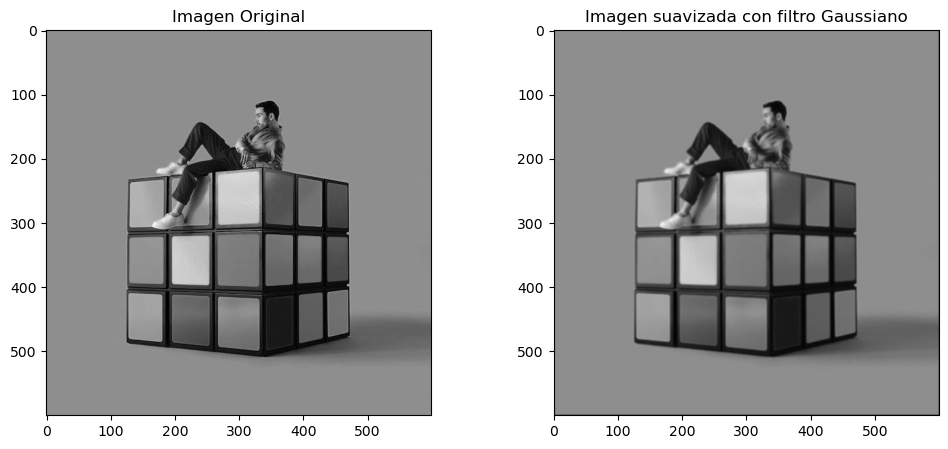

In [39]:
gauss = convolucion(imagen_rgb, kernelGauss(5))
gauss = gauss.astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax1, ax2 = axs.flatten()

ax1.imshow(imagen_gris, cmap='gray')
ax1.set_title('Imagen Original')

ax2.imshow(gauss, cmap='jet')
ax2.set_title('Imagen suavizada con filtro Gaussiano')
plt.show()

In [41]:
def sobel(grayscale_image):
    Gx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
    Gy = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]])
    [rows, columns] = np.shape(grayscale_image)
    gradientX = np.zeros(shape=(rows, columns))
    gradientY = np.zeros(shape=(rows, columns))

    for i in range(1, rows - 1):
        for j in range(1, columns - 1):
            gx = np.sum(np.multiply(Gx, grayscale_image[i-1:i+2, j-1:j+2]))  # Convolution in the x direction
            gy = np.sum(np.multiply(Gy, grayscale_image[i-1:i+2, j-1:j+2]))  # Convolution in the y direction
            gradientX[i, j] = gx
            gradientY[i, j] = gy

    return gradientX, gradientY

In [42]:
sobelResults = sobel(gauss[:,:,0])

In [43]:
gradientX = sobelResults[0]
gradientY = sobelResults[1]

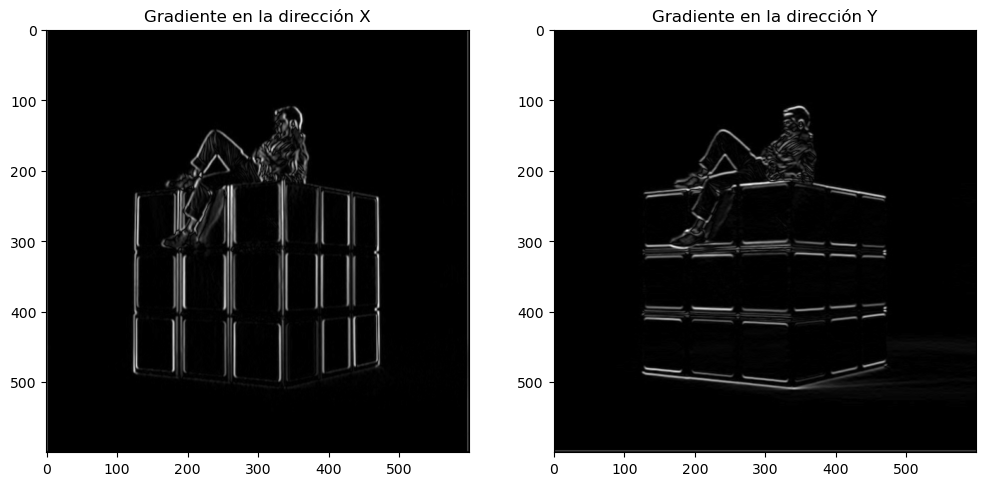

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(gradientX), cmap='gray')
plt.title('Gradiente en la dirección X')

plt.subplot(1, 2, 2)
plt.imshow(np.abs(gradientY), cmap='gray')
plt.title('Gradiente en la dirección Y')

plt.show()


In [51]:
magnitudeG = np.sqrt(gradientX**2 + gradientY**2)
directionG = np.arctan2(gradientY, gradientX) * (180 / np.pi)

In [52]:
def NMaxSuppression(magnitudeG, directionG):
    rows, cols = magnitudeG.shape
    result = np.zeros_like(magnitudeG, dtype=np.uint8)
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            angle = directionG[i, j]
            mag = magnitudeG[i, j]
            
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                neighbor1 = magnitudeG[i, j + 1]
                neighbor2 = magnitudeG[i, j - 1]
            elif (22.5 <= angle < 67.5):
                neighbor1 = magnitudeG[i + 1, j - 1]
                neighbor2 = magnitudeG[i - 1, j + 1]
            elif (67.5 <= angle < 112.5):
                neighbor1 = magnitudeG[i + 1, j]
                neighbor2 = magnitudeG[i - 1, j]
            else:
                neighbor1 = magnitudeG[i - 1, j - 1]
                neighbor2 = magnitudeG[i + 1, j + 1]

            if mag >= neighbor1 and mag >= neighbor2:
                result[i, j] = mag
    
    return result

In [53]:
suppressEdge = NMaxSuppression(magnitudeG, directionG)

Text(0.5, 1.0, 'Resultado de Supresión de Bordes')

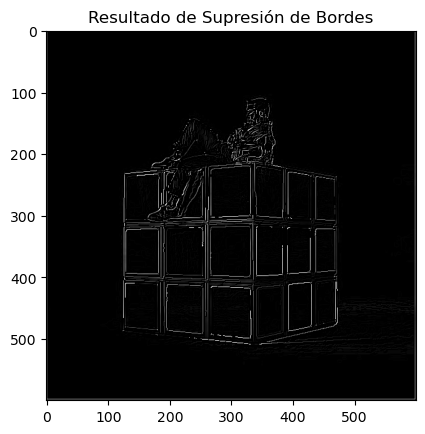

In [66]:
plt.imshow(suppressEdge, cmap='gray')
plt.title('Resultado de Supresión de Bordes')

In [74]:
def canny(image, ratioL=0.05, ratioH=0.09, debilP = 25, fuerteP = 255 ):
    umbralAlto = np.max(image) * ratioH
    umbralBajo = umbralAlto * ratioL
    
    edge_image = np.zeros_like(image, dtype=np.int32)
    
    # djamos solamente los pixeles que tengan o superen el valor alto
    strong_i, strong_j = np.where(image >= umbralAlto)
    
    weak_i, weak_j = np.where((image >= umbralBajo) & (image < umbralAlto))
    
    #Se marcan ambos valores en los bordes finales
    edge_image[strong_i, strong_j] = fuerteP
    edge_image[weak_i, weak_j] = debilP
    
    #se devuelve el valor fuerte, debil y la imagen de los bordes generalers
    return (edge_image, debilP, fuerteP)


In [75]:
thresholding =  canny(suppressEdge)


25 255


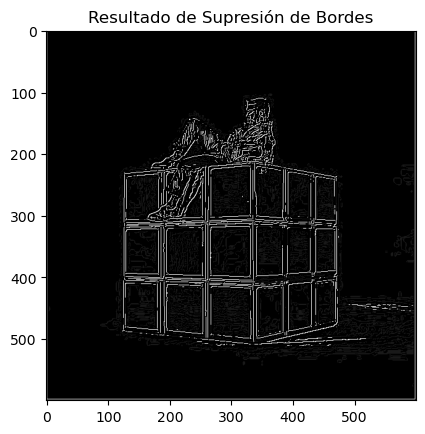

In [84]:
bordesG = thresholding[0]
pixelD = thresholding[1]
pixelF = thresholding[2]
plt.imshow(bordesG, cmap='gray')
plt.title('Resultado de Supresión de Bordes')
print(pixelD, pixelF)

In [82]:
def hysteresis(image, weak, strong=255):
    height, width = image.shape  
    for i in range(1, height-1):
        for j in range(1, width-1):
            if (image[i, j] == weak):
                #se busca en los pixeles aledaños y si al menos uno es fuerte se convierte en uno 
                    if ((image[i+1, j-1] == strong) or (image[i+1, j] == strong) or (image[i+1, j+1] == strong)
                        or (image[i, j-1] == strong) or (image[i, j+1] == strong)
                        or (image[i-1, j-1] == strong) or (image[i-1, j] == strong) or (image[i-1, j+1] == strong)):
                        image[i, j] = strong
                    else:
                        image[i, j] = 0
    return image

In [85]:
finalCanny = hysteresis(bordesG, pixelD)

Text(0.5, 1.0, 'Resultado Canny')

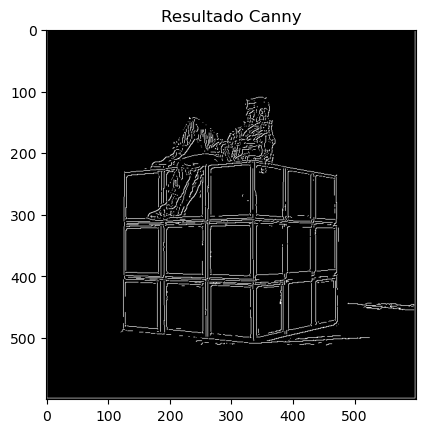

In [86]:
plt.imshow(finalCanny, cmap='gray')
plt.title('Resultado Canny')